In [1]:
import sys
PATH_FOR_PROJECT = "/home/louis/Dropbox/ConsultationSimpliphAI/" \
           "AnalytiqueBourassaGit/UncertaintyForecasting/"
sys.path.append(PATH_FOR_PROJECT)

In [2]:
from tqdm import tqdm
import itertools

from models.model_data_feeder import *
from visualisations.visualisations import Visualisator
from models.training_tools.early_stopping import EarlyStopping


# 0. Define experiment parameters

In [3]:
from models.script_parameters.parameters import ExperimentParameters

In [4]:
IS_DROPOUT_WITH_CORRELATION = False
early_stopper = EarlyStopping(patience=4, verbose=True)

experiment_params = ExperimentParameters()

experiment_params.path = "/home/louis/Documents/ConsultationSimpliphAI/" \
           "AnalytiqueBourassaGit/UncertaintyForecasting/models/LSTM_BayesRegressor/.models/"

path_results = "/home/louis/Documents/ConsultationSimpliphAI/" \
           "AnalytiqueBourassaGit/UncertaintyForecasting/models/LSTM_BayesRegressor/"


experiment_params.version = "v0.1.0"
experiment_params.show_figures = True
experiment_params.smoke_test = False
experiment_params.train_lstm = True
experiment_params.save_lstm = False
experiment_params.type_of_data = "autoregressive-5" # options are sin or "autoregressive-5"
experiment_params.name = "feature_extractor_" + experiment_params.type_of_data




# 1.  generate data from ARMA process

In [5]:
from data_handling.data_reshaping import reshape_data_for_LSTM, reshape_into_sequences
from data_generation.data_generators_switcher import DatageneratorsSwitcher

In [6]:
n_data = 1000
length_of_sequences = 7 + 1

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


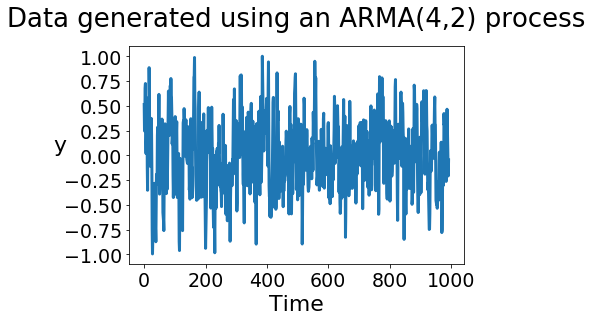

In [7]:
data_generator = DatageneratorsSwitcher(experiment_params.type_of_data)
data = data_generator(n_data)

sequences = reshape_into_sequences(data, length_of_sequences)
all_data = reshape_data_for_LSTM(sequences)

training_data_labels = all_data[length_of_sequences-1, :, 0]

number_of_train_data = floor(0.5*n_data)
val_set_end = floor(0.7*n_data)

data_train = all_data[:, :number_of_train_data, :]
data_validation = all_data[:, number_of_train_data:val_set_end, :]

if experiment_params.show_figures:
    Visualisator.show_time_series(data=all_data[length_of_sequences-2, :, 0],
                                  title="Data generated using an ARMA(4,2) process")

# 2 . Train model

## 2.1 Define parameters of model and optimizer

In [8]:
from models.regression.LSTM_CorrelatedDropout.LSTM_not_correlated_dropout import LSTM_not_correlated_dropout
from models.regression.LSTM_CorrelatedDropout.losses import LossRegressionGaussianNoCorrelations

from models.regression.LSTM_CorrelatedDropout.LSTM_correlated_dropout import LSTM_correlated_dropout
from models.regression.LSTM_CorrelatedDropout.losses import LossRegressionGaussianWithCorrelations

from models.lstm_params import LSTM_parameters

In [9]:
lstm_params = LSTM_parameters()
lstm_params.batch_size = 20
lstm_params.hidden_dim = 5
lstm_params.dropout = 0.0

if experiment_params.train_lstm is False:
    lstm_params.load("lstm_params_" + experiment_params.name + "_" + experiment_params.version, experiment_params.path)

learning_rate = 1e-3
num_epochs = 20 if not experiment_params.smoke_test else 1
num_epochs_pretraining = 500 if not experiment_params.smoke_test else 1

In [10]:
if IS_DROPOUT_WITH_CORRELATION:
    model = LSTM_correlated_dropout(lstm_params)
else:
    model = LSTM_not_correlated_dropout(lstm_params)

In [11]:
model.cuda()
model.show_summary()

**************************************
weights mu:  tensor([0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)
covariance:  tensor([[0.1073],
        [0.1121],
        [0.1516],
        [0.1142],
        [0.1701],
        [0.1331]], device='cuda:0', requires_grad=True)
sigma:  tensor([0.0100], device='cuda:0', requires_grad=True)
**************************************


In [12]:
if IS_DROPOUT_WITH_CORRELATION:
    loss_fn = LossRegressionGaussianWithCorrelations(0.1, lstm_params.hidden_dim)
else:
    loss_fn = LossRegressionGaussianNoCorrelations(0.1, lstm_params.hidden_dim)

In [13]:
params = list(model.parameters()) + list(model.prediction_sigma)

optimizer_1 = torch.optim.Adam(itertools.chain(model.parameters(),[model.weights_mu]),
                             lr=learning_rate)

optimizer_2 = torch.optim.Adam(itertools.chain( [model.weights_mu,
                                                                  # model.prediction_sigma,
                                                                  model.covariance_vector]),
                             lr=5e-3)

loss_function_pretraining = torch.nn.MSELoss(size_average=False)

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## 2.2 Pretraining of LSTM with auxiliary loss

In [14]:
if experiment_params.train_lstm:

    hist_1 = np.zeros(num_epochs_pretraining)
    for epoch in tqdm(range(num_epochs_pretraining)):
        model.hidden = model.init_hidden()

        losses, N_data = make_forward_pass(data_loader_sequences, model, loss_function_pretraining, data_train,
                                                           lstm_params.batch_size)

        hist_1[epoch] = losses

        optimizer_1.zero_grad()
        losses.backward()
        optimizer_1.step()

    model.is_pretraining = False
    model.show_summary()

100%|██████████| 500/500 [00:19<00:00, 27.19it/s]

Message: the weights of the lstm have been freezed.
**************************************
weights mu:  tensor([ 0.5133,  0.4604,  0.3536, -0.3552, -0.4057,  0.0485], device='cuda:0',
       requires_grad=True)
covariance:  tensor([[0.1073],
        [0.1121],
        [0.1516],
        [0.1142],
        [0.1701],
        [0.1331]], device='cuda:0', requires_grad=True)
sigma:  tensor([0.0100], device='cuda:0', requires_grad=True)
**************************************


## 2.2 Training of baysesian parameters with variational loss

In [15]:
if experiment_params.train_lstm:
    
    hist = np.zeros(num_epochs)
    for epoch in tqdm(range(num_epochs)):
        model.hidden = model.init_hidden()

        losses, N_data = make_forward_pass_output_specific(data_loader_sequences, model, loss_fn, data_train, lstm_params.batch_size)

        hist[epoch] = losses

        optimizer_2.zero_grad()
        losses.backward()
        optimizer_2.step()

100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


## 2.3 Saving or loading of model if specified

In [16]:
from models.disk_reader_and_writer import save_checkpoint, load_checkpoint

In [17]:
if not experiment_params.train_lstm:

    load_checkpoint(model, optimizer_2, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)

if experiment_params.save_lstm:
    save_checkpoint(model, optimizer_2, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)
    lstm_params.save(experiment_params.version, experiment_params.path)



# 3. Anlysis of results

In [18]:
y_pred, y_true = make_predictions(data_loader_sequences, model, all_data, lstm_params.batch_size)

number_of_train_data = floor(0.7*n_data)
y_train, y_test = y_true[:number_of_train_data], y_true[number_of_train_data:]

model.show_summary()

**************************************
weights mu:  tensor([ 0.5222,  0.4862,  0.3534, -0.3645, -0.4181,  0.0483], device='cuda:0',
       requires_grad=True)
covariance:  tensor([[0.0425],
        [0.0413],
        [0.0657],
        [0.0401],
        [0.0837],
        [0.0442]], device='cuda:0', requires_grad=True)
sigma:  tensor([0.0100], device='cuda:0', requires_grad=True)
**************************************


## 3.1 Loss convergence

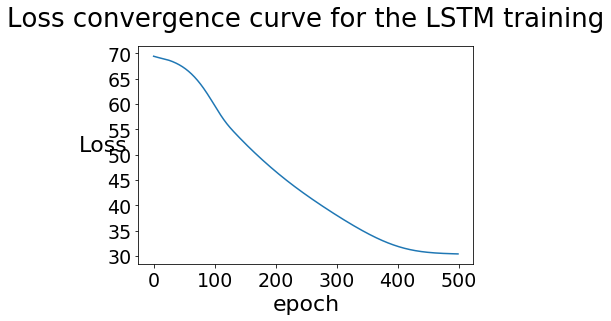

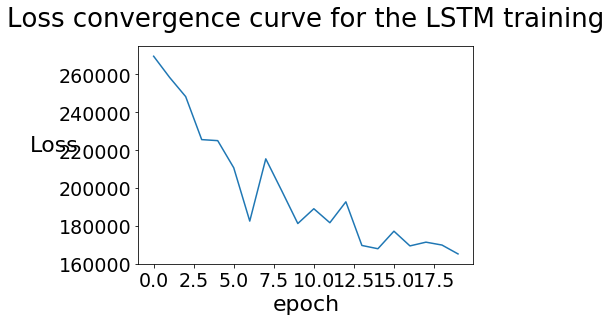

In [19]:

if experiment_params.show_figures:

    if experiment_params.train_lstm:

        Visualisator.show_epoch_convergence(data=hist_1,
                                            name="Loss",
                                            title="Loss convergence curve for the LSTM training",
                                            number_of_burned_step=0)

        Visualisator.show_epoch_convergence(data=hist,
                                            name="Loss",
                                            title="Loss convergence curve for the LSTM training",
                                            number_of_burned_step=0)

## 3.2 Visualisation of results with confidence interval

In [20]:
from probabilitic_predictions.probabilistic_predictions_regression import ProbabilisticPredictionsRegression

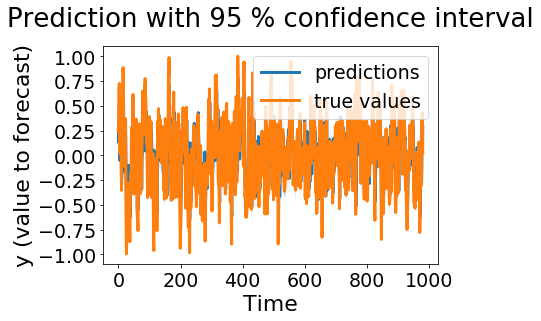

In [21]:
predictions = ProbabilisticPredictionsRegression()
predictions.number_of_predictions = y_pred.shape[0]
predictions.number_of_samples = y_pred.shape[1]
predictions.initialize_to_zeros()

predictions.values = y_pred
predictions.true_values = y_true
predictions.show_predictions_with_confidence_interval(0.95)

## 3.3 Calibration analysis

In [22]:
from models.calibration.diagnostics import calculate_one_sided_cumulative_calibration, calculate_confidence_interval_calibration, calculate_marginal_calibration
from models.calibration.analysis import show_analysis

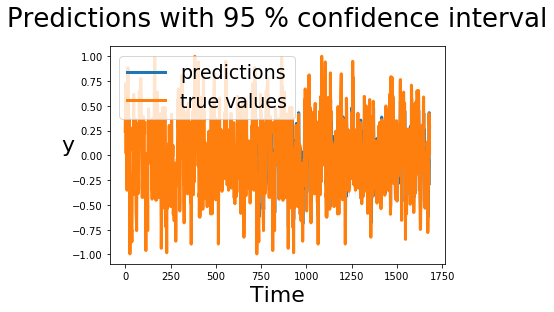

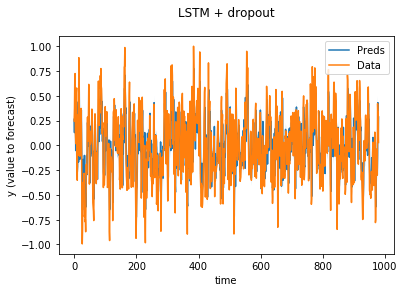

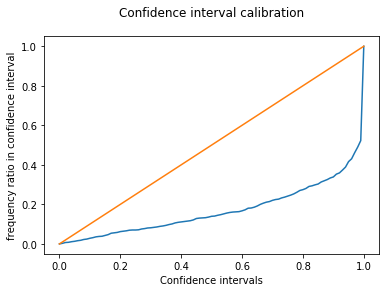

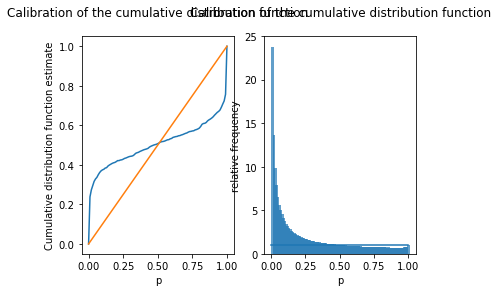

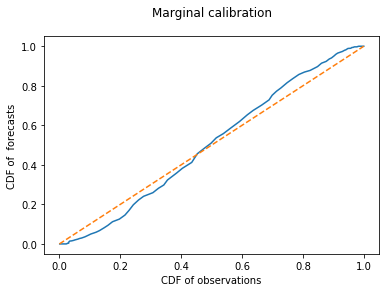

 deviation_score_probabilistic_calibration: 0.33040 
 deviation_score_exceedance_calibration: 0.16259 
 deviation_score_marginal_calibration: 0.04068 


In [23]:
deviation_score_probabilistic_calibration = calculate_confidence_interval_calibration(predictions.values, predictions.true_values)
deviation_score_exceedance_calibration = calculate_one_sided_cumulative_calibration(predictions.values, predictions.true_values)
deviation_score_marginal_calibration = calculate_marginal_calibration(predictions.values, predictions.true_values)

predictions.train_data = y_train
predictions.show_predictions_with_training_data(confidence_interval=0.95)

show_analysis(predictions.values, predictions.true_values, name="LSTM + dropout")